In [2]:
import os
import re
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from tensorflow import keras
from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup

In [3]:
print(os.listdir("./data"))

['train.tsv', 'test.tsv', 'streamlit.csv', 'test_results.csv']


In [4]:
train=pd.read_csv("./data/train.tsv", sep="\t")
print(train.sample())
print("Train shape: ", train.shape)

       PhraseId  SentenceId         Phrase  Sentiment
30356     30357        1409  inappropriate          1
Train shape:  (156060, 4)


In [5]:
def clean_sentences(df):
    reviews = []

    for sentence in tqdm(df['Phrase']):
        if type(sentence) is not str:
            sentence = str(sentence)

        #remove html content
        review_text = BeautifulSoup(sentence, features="html.parser").get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)
        
    return(reviews)

In [6]:
print("Cleaning train sentences...")
train_sentences = clean_sentences(train)
print("Train sentences count: ", len(train_sentences))

Cleaning train sentences...


100%|████████████████████████████████| 156060/156060 [00:07<00:00, 20220.08it/s]

Train sentences count:  156060


In [7]:
target=train['Sentiment'].values
y_target=keras.utils.to_categorical(target)
num_classes=y_target.shape[1]
print("Number of classes: ", num_classes)

Number of classes:  5


In [8]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

unique_words = set()
len_max = 0

for sentence in X_train:
    unique_words.update(sentence)
    
    if(len_max<len(sentence)):
        len_max = len(sentence)
        
print("Unique words count: ", len(list(unique_words)))
print("Max review length: ", len_max)

Unique words count:  13736
Max review length:  48


In [9]:
X_train_s = [' '.join(word_list) for word_list in X_train]
X_val_s = [' '.join(word_list) for word_list in X_val]

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=len(list(unique_words))+2,
    pad_to_max_tokens=True,
    output_mode='int',
    output_sequence_length=len_max)

vectorize_layer.adapt(X_train_s)

In [10]:
early_stopping = keras.callbacks.EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [11]:
model=keras.models.Sequential()
model.add(keras.layers.Embedding(len(list(unique_words))+2,300,input_length=len_max))
model.add(keras.layers.LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(keras.layers.LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
X_train_v = vectorize_layer(np.array(X_train_s))
X_val_v = vectorize_layer(np.array(X_val_s))

history=model.fit(X_train_v, y_train, validation_data=(X_val_v, y_val),epochs=10, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 90s 185ms/step - accuracy: 0.5674 - loss: 1.0744 - val_accuracy: 0.6355 - val_loss: 0.8963
Epoch 2/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 94s 194ms/step - accuracy: 0.6595 - loss: 0.8498 - val_accuracy: 0.6511 - val_loss: 0.8388
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 97s 198ms/step - accuracy: 0.6780 - loss: 0.7835 - val_accuracy: 0.6588 - val_loss: 0.8264
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 95s 194ms/step - accuracy: 0.6882 - loss: 0.7492 - val_accuracy: 0.6636 - val_loss: 0.8263
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 96s 197ms/step - accuracy: 0.6976 - loss: 0.7310 - val_accuracy: 0.6613 - val_loss: 0.8331
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 97s 199ms/step - accuracy: 0.7033 - loss: 0.7134 - val_accuracy: 0.6664 - val_loss: 0.8320
Epoch 7/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 97s 198ms/step - accuracy: 0.7050 - loss: 0.7048 - val_accuracy: 0.6682 - val_loss: 0.8370
Epoch 8/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 99s 203ms/step - accuracy: 0.7101 - loss: 0

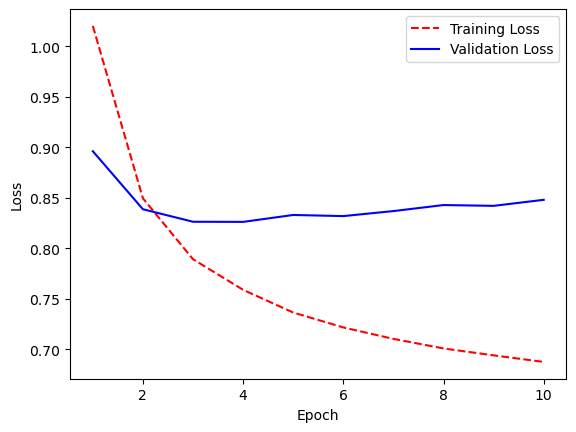

In [16]:
import matplotlib.pyplot as plt

epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

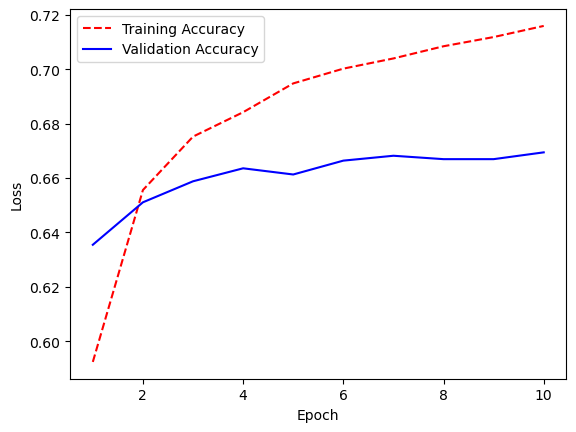

In [17]:
import matplotlib.pyplot as plt

epoch_count = range(1, len(history.history['accuracy']) + 1)

plt.plot(epoch_count, history.history['accuracy'], 'r--')
plt.plot(epoch_count, history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [17]:
test=pd.read_csv("./data/test.tsv", sep="\t")
print(test.sample())
print("Test shape: ", test.shape)

       PhraseId  SentenceId      Phrase
50676    206737       10992  as a board
Test shape:  (66292, 3)


In [18]:
print("Cleaning test sentences...")
test_sentences = clean_sentences(test)
print("Test sentences count: ", len(test_sentences))

Cleaning test sentences...


100%|██████████████████████████████████| 66292/66292 [00:03<00:00, 22091.93it/s]

Test sentences count:  66292


In [19]:
X_test_s = [' '.join(word_list) for word_list in test_sentences]
X_test_v = vectorize_layer(np.array(X_test_s))

In [20]:
y_test = model.predict(X_test_v)

2072/2072 ━━━━━━━━━━━━━━━━━━━━ 56s 27ms/step


In [100]:
test['Sentiment']=np.argmax(y_test, axis=1)
test.to_csv('./data/test_results.csv', index=False)

In [21]:
y_val_pred = model.predict(X_val_v)


976/976 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step


In [35]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

indices = np.argmax(y_val_pred, axis=1)
y_val_pred = np.eye(y_val_pred.shape[1])[indices]

print(y_val, y_val_pred)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]] [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


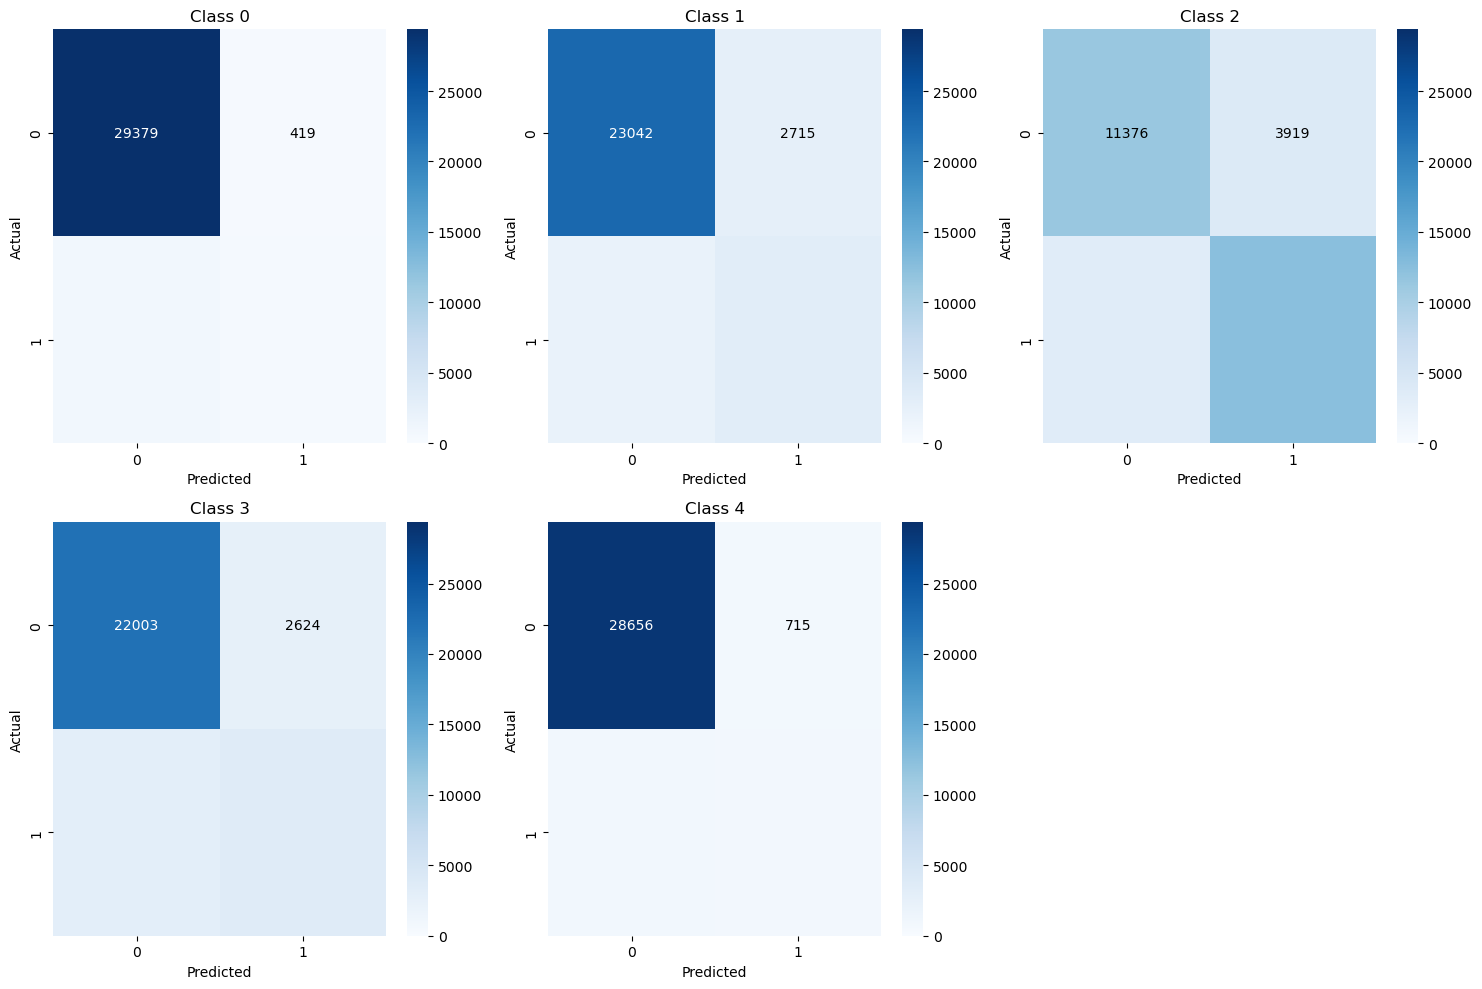

In [54]:
mcm = multilabel_confusion_matrix(np.array(y_val), np.array(y_val_pred))

# Create a subplot for each confusion matrix
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, matrix in enumerate(mcm):
    ax = axes[i//3, i%3]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=np.max(mcm), ax=ax)

    # Change the color of the annotations based on the cell color
    for text in ax.texts:
        text.set_color("white" if float(text.get_text()) > np.max(mcm)/2 else "black")
        
    ax.set_title(f'Class {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Remove the empty subplot (if any)
if len(mcm) < 6:
    fig.delaxes(axes.flatten()[len(mcm)])

plt.tight_layout()
plt.show()